# How to import a coder generated module into ThermoEngine
## Demonstrates importing both stoichiometric and solution phase modules 
import ThermoEngine libraries ...

In [1]:
from thermoengine import core, model, phases
import numpy as np

This notebook tests functionality of objective-C modules and *coder* generated modules for a pure phase ("Potassium Feldspar", "Or") and a solution phase ("Feldspar", "Fsp"). Examples of producing suitable *coder* generated modules may be found in the notebooks:
- Example-1-Berman-std-state
- Example-7-Simple-Solution

If *coder* generated modules are tested, the code files produced by the *coder* module must be contained in the folder *working* located in the same directory as this notebook. This folder must also house the Cython (module_name.pyx) and Distutil (module_name.pyxbld) files defining the python interface to the module and the compilation/link instructions.  

If you are testing *coder* derived modules with this notebook, ensure that the **calibration flag** set below **matches that specified when the working code was generated by the *coder* module**.  

## Options:

***use_pure_phases***
- True: Run tests on the stoichiometric phase *Potassium_Feldspar*
- False: Run tests on the new solution phase *Garnet*

In [2]:
use_pure_phase = False

***use_coder_module***
- True: Use phase modules generated by *coder*. Files must be avaialble in the *working* folder. They can be produced by running notebook *Example-1* (stoichiometric phase) or *Example-1* + *Example-7* (that together produced code for a solution phase)
- False: Use phase modules derived from the Berman (1988) database

In [3]:
use_coder_module = True

***calib***
- True: Test code that implements parameter calibration methods.  If *coder* module code is used, then ensure that the *calib* flag was set to *True* when that code was generated.
- False: Test code that does not implement the parameter calibration methods.  See above.

In [4]:
calib = True

In [12]:
pwd

'/Users/jennaadams/Documents/projects/ThermoEngine/Notebooks/Codegen'

## Load the module into ThermoEngine:
Initialize a model class using the options specified above and display some information about the model implementation ...

In [5]:
if use_coder_module:
    %cd working
    from pyximport import install
    install()
    if use_pure_phase:
        import berman
    else:
        import Garnet_Solution
    %cd ..
    if use_pure_phase:
        modelDB = model.Database(database="CoderModule", calib=calib, 
                                 phase_tuple=('berman', {'Or':['Potassium_Feldspar','pure']}))
    else:
        modelDB = model.Database(database="CoderModule", calib=calib, 
                                 phase_tuple=('Garnet_Solution', {'Grt':['Garnet','solution']}))
else:
    modelDB = model.Database()

if use_pure_phase:
    phase = modelDB.get_phase('Or')
else:
    phase = modelDB.get_phase('Grt')

for phase_name, abbrv in zip(modelDB.phase_info.phase_name,modelDB.phase_info.abbrev):
    print ('Abbreviation: {0:<10s} Name: {1:<30s}'.format(abbrv, phase_name))

/Users/jennaadams/Documents/projects/ThermoEngine/Notebooks/Codegen/working
/Users/jennaadams/Documents/projects/ThermoEngine/Notebooks/Codegen
Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on species properties. Species are proxied by components.
Abbreviation: Grt        Name: Garnet                        
Abbreviation: Liq        Name: Liquid                        
Abbreviation: H2O        Name: Water                         


## Obtain information about this module:

In [6]:
if use_pure_phase:
    print (phase.props['phase_name'])
    print (phase.props['formula'][0])
    print (phase.props['molwt'][0])
else:
    print (phase.props['phase_name'])
    print (phase.props['formula'])
    print (phase.props['molwt'])
    print (phase.props['abbrev'])
    print (phase.props['endmember_num'])
    print (phase.props['endmember_name'])

Garnet
['Si3Fe3Al2O12' 'Ca3Al2Si3O12' 'Mg3Al2Si3O12']
[497.75338 450.45238 403.12738]
Grt
3
['Almandine' 'Grossular' 'Pyrope']


## For solutions, specify composition of the phase:

In [7]:
if use_pure_phase:
    moles_end = None
else:
    mol_oxides = core.chem.format_mol_oxide_comp({'SiO2':42.60,'Al2O3':22.71, 'TiO2':0.41, 'FeO':7.14, 'CaO':4.26, 
                                                  'Cr2O3':0.53, 'MgO':22.08, 'MnO':0}, convert_grams_to_moles=True)
    moles_end, mol_ox_model, oxide_res, success = phase.calc_endmember_comp(mol_oxide_comp=mol_oxides, method='intrinsic', output_residual=True)
    for i in range(0,phase.props['endmember_num']):
        print ("mole number of {0:10.10s} = {1:13.6e}".format(phase.props['endmember_name'][i], moles_end[i]))
    if not phase.test_endmember_comp(moles_end):
        print ("Calculated composition is infeasible!")
    print ('Formula: ', phase.compute_formula(1000.0, 1000.0, moles_end))
    print ('Total moles of endmembers: ', phase.covert_endmember_comp(moles_end,output='total_moles'))
    mol_elm = phase.covert_endmember_comp(moles_end,output='moles_elements')
    print ('Mole fractions of endmembers: ', phase.covert_endmember_comp(moles_end,output='mole_fraction'))
    print ('Moles of endmembers: ', phase.convert_elements(mol_elm, output='moles_end'))
    print ('Total moles of endmembers: ', phase.convert_elements(mol_elm, output='total_moles'))
    print ('Total grams of phase: ', phase.convert_elements(mol_elm, output='total_grams'))
    # Check if intrinsic mode fails
    if len(moles_end) == 0:
        print ('Intrinsic mode returned an empty array; estimating composition ...')
        moles_end = np.array([0.20813521, 0.00267478, 0.14968884])
        print (moles_end)

mole number of Almandine  =  9.937867e-02
mole number of Grossular  =  7.596372e-02
mole number of Pyrope     =  5.478310e-01
Formula:  (Mg2.273Fe0.412Ca0.315)(Al2.000)Si3O12
Total moles of endmembers:  0.7231734034139843
Mole fractions of endmembers:  [0.13742026 0.1050422  0.75753755]
Moles of endmembers:  [0.29813602 0.22789117 1.64349302]
Total moles of endmembers:  2.169520210241953
Total grams of phase:  913.5893671268603


## All phases should implement the following functions:
where *T* (temperature) is in K, and *P* (pressure) is in bars.  Note that for stoichiometric phases, compositional derivatives are not implemented. In addition, Some functions are only available in code generated by the coder module.  These functions return a scalar or an (multi-dimensional) array, depending on input.

In [8]:
def test_func(name, func, t, p, units, deriv=None, const=None, endmember=None):
    global moles_end
    try:
        if deriv:
            result = func(t, p, deriv=deriv, mol=moles_end)
            if type(result) is np.ndarray:
                if len(result.shape) == 2:
                    print ("{0:>10s}".format(name), end=' ')
                    for x in result[0]:
                        print ("{0:15.6e}".format(x), end=' ')
                    print (" {0:<20s}".format(units))
                elif len(result.shape) == 3:
                    for i in range(0,result.shape[1]):
                        print ("{0:>10s}".format(name), end=' ')
                        for x in result[0][i]:
                            print ("{0:15.6e}".format(x), end=' ')
                        print (" {0:<20s}".format(units))
                elif len(result.shape) == 4:
                    for i in range(0,result.shape[1]):
                        for j in range(0,result.shape[2]):
                            print ("{0:>10s}".format(name), end=' ')
                            for x in result[0][i][j]:
                                print ("{0:15.6e}".format(x), end=' ')
                            print (" {0:<20s}".format(units))
                elif len(result.shape) == 1:
                    print ("{0:>10s}".format(name), end=' ')
                    for x in result:
                        print ("{0:15.6e}".format(x), end=' ')
                    print (" {0:<20s}".format(units))
                else:
                    print ('A', result.shape)
            else:
                print ("{0:>10s}{1:15.6e} {2:<20s}".format(name, result, units))
        elif const:
            print ("{0:>10s}{1:15.6e} {2:<20s}".format(name, func(t, p, const=const, mol=moles_end), units))
        else:
            result = func(t, p, mol=moles_end)
            if type(result) is np.ndarray:
                if len(result.shape) == 2:
                    print ("{0:>10s}".format(name), end=' ')
                    for x in result[0]:
                        print ("{0:15.6e}".format(x), end=' ')
                    print (" {0:<20s}".format(units))
                elif len(result.shape) == 1:
                    print ("{0:>10s}".format(name), end=' ')
                    for x in result:
                        print ("{0:15.6e}".format(x), end=' ')
                    print (" {0:<20s}".format(units))
                else:
                    print ('B', len(result.shape))
            else:
                print ("{0:>10s}{1:15.6e} {2:<20s}".format(name, result, units))
    except AttributeError:
        print ("{0:>10s} is not implemented".format(name))

test_func('G',  phase.gibbs_energy, 1000.0, 1000.0, 'J/mol')
test_func('dG/dT', phase.gibbs_energy, 1000.0, 1000.0, 'J/K-mol', deriv={'dT':1})
test_func('dG/dP', phase.gibbs_energy, 1000.0, 1000.0, 'J/bar-mol', deriv={'dP':1})
test_func('dG/dm', phase.gibbs_energy, 1000.0, 1000.0, 'J/mol^2', deriv={'dmol':1})

test_func('d2G/dT2', phase.gibbs_energy, 1000.0, 1000.0, 'J/K^2-mol', deriv={'dT':2})
test_func('d2G/dTdP', phase.gibbs_energy, 1000.0, 1000.0, 'J/K-bar-mol', deriv={'dT':1, 'dP':1})
test_func('d2G/dTdm', phase.gibbs_energy, 1000.0, 1000.0, 'J/K-mol^2', deriv={'dT':1, 'dmol':1})
test_func('d2G/dP2', phase.gibbs_energy, 1000.0, 1000.0, 'J/bar^2-mol', deriv={'dP':2})
test_func('d2G/dPdm', phase.gibbs_energy, 1000.0, 1000.0, 'J/bar-mol^2', deriv={'dP':1, 'dmol':1})
test_func('d2G/dm2', phase.gibbs_energy, 1000.0, 1000.0, 'J/mol^3', deriv={'dmol':2})

test_func('d3G/dT3', phase.gibbs_energy, 1000.0, 1000.0, 'J/K^3-mol', deriv={'dT':3})
test_func('d3G/dT2dP', phase.gibbs_energy, 1000.0, 1000.0, 'J/K^2-bar-mol', deriv={'dT':2, 'dP':1})
test_func('d3G/dT2dm', phase.gibbs_energy, 1000.0, 1000.0, 'J/K^2-mol^2', deriv={'dT':2, 'dmol':1})
test_func('d3G/dTdP2', phase.gibbs_energy, 1000.0, 1000.0, 'J/K-bar^2-mol', deriv={'dT':1, 'dP':2})
test_func('d3G/dTdPdm', phase.gibbs_energy, 1000.0, 1000.0, 'J/K-bar-mol^2', deriv={'dT':1, 'dP':1, 'dmol':1})
test_func('d3G/dTdm2', phase.gibbs_energy, 1000.0, 1000.0, 'J/K-mol^3', deriv={'dT':1, 'dmol':2})
test_func('d3G/dP3', phase.gibbs_energy, 1000.0, 1000.0, 'J/bar^3-mol', deriv={'dP':3})
test_func('d3G/dP2dm', phase.gibbs_energy, 1000.0, 1000.0, 'J/bar^2-mol^2', deriv={'dP':2, 'dmol':1})
test_func('d3G/dPdm2', phase.gibbs_energy, 1000.0, 1000.0, 'J/bar-mol^3', deriv={'dP':1, 'dmol':2})
test_func('d3G/dm3', phase.gibbs_energy, 1000.0, 1000.0, 'J/mol^4', deriv={'dmol':3})

test_func('H', phase.enthalpy, 1000.0, 1000.0, 'J/mol')
test_func('S', phase.entropy, 1000.0, 1000.0, 'J/K-mol')
test_func('dS/dm', phase.entropy, 1000.0, 1000.0, 'J/K-mol^2', deriv={'dmol':1})
test_func('d2S/dm2', phase.entropy, 1000.0, 1000.0, 'J/K-mol^3', deriv={'dmol':2})

test_func('Cv', phase.heat_capacity, 1000.0, 1000.0, 'J/K-mol', const='V')
test_func('Cp', phase.heat_capacity, 1000.0, 1000.0, 'J/K-mol')
test_func('dCp/dT', phase.heat_capacity, 1000.0, 1000.0, 'J/-K^2-mol', deriv={'dT':1})
test_func('dCp/dm', phase.heat_capacity, 1000.0, 1000.0, 'J/-K-mol^2', deriv={'dmol':1})

test_func('rho', phase.density, 1000.0, 1000.0, 'gm/cc')
test_func('alpha', phase.thermal_exp, 1000.0, 1000.0, '1/K')
test_func('beta', phase.compressibility, 1000.0, 1000.0, '1/bar')
test_func('K', phase.bulk_mod, 1000.0, 1000.0, '')
test_func('Kp', phase.bulk_mod, 1000.0, 1000.0, '1/bar', deriv={'dP':1})

test_func("V", phase.volume, 1000.0, 1000.0, 'J/bar-mol')
test_func("dV/dT", phase.volume, 1000.0, 1000.0, 'J/bar-K-mol', deriv={'dT':1})
test_func("dv/dP", phase.volume, 1000.0, 1000.0, 'J/bar^2-mol', deriv={'dP':1})
test_func("dv/dm", phase.volume, 1000.0, 1000.0, 'J/bar-mol^2', deriv={'dP':1, 'dmol':1})
test_func("d2V/dT2", phase.volume, 1000.0, 1000.0, 'J/bar-K^2-mol', deriv={'dT':2})
test_func("d2V/dTdP", phase.volume, 1000.0, 1000.0, 'J/bar^2-K-mol', deriv={'dT':1, 'dP':1})
test_func("d2V/dP2", phase.volume, 1000.0, 1000.0, 'J/bar^3-mol', deriv={'dP':2})
test_func("d2V/dTdm", phase.volume, 1000.0, 1000.0, 'J/bar-K-mol^2', deriv={'dT':1, 'dmol':1})
test_func("d2V/dPdm", phase.volume, 1000.0, 1000.0, 'J/bar^2-mol^2', deriv={'dP':1, 'dmol':1})
test_func("d2V/dm2", phase.volume, 1000.0, 1000.0, 'J/bar-mol^3', deriv={'dmol':2})

test_func('mu0', phase.chem_potential, 1000.0, 1000.0, 'J/mol')
test_func('activity', phase.activity, 1000.0, 1000.0, '')
test_func('da/dm', phase.activity, 1000.0, 1000.0, '1/mol', deriv={'dmol':1})

         G  -4.812170e+06 J/mol               
     dG/dT  -5.769101e+02 J/K-mol             
     dG/dP   8.463252e+00 J/bar-mol           
     dG/dm   -5.802765e+06   -7.096968e+06   -6.747313e+06  J/mol^2             
   d2G/dT2  -3.570348e-01 J/K^2-mol           
  d2G/dTdP   2.339173e-04 J/K-bar-mol         
  d2G/dTdm   -8.941115e+02   -7.953817e+02   -7.805954e+02  J/K-mol^2           
   d2G/dP2  -4.832901e-06 J/bar^2-mol         
  d2G/dPdm    1.190404e+01    1.276548e+01    1.151912e+01  J/bar-mol^2         
   d2G/dm2   -1.977869e+04    3.081284e+04   -6.846596e+02    8.426000e+04   -1.727329e+04    2.519361e+03  J/mol^3             
   d3G/dT3   3.011724e-04 J/K^3-mol           
 d3G/dT2dP   7.827264e-08 J/K^2-bar-mol       
 d3G/dT2dm   -5.026189e-01   -4.921705e-01   -4.923016e-01  J/K^2-mol^2         
 d3G/dTdP2   0.000000e+00 J/K-bar^2-mol       
d3G/dTdPdm    3.354334e-04    3.789460e-04    3.135934e-04  J/K-bar-mol^2       
 d3G/dTdm2    9.994325e+01   -4.464523e+01 

## Illustrate parameter calibration protocol methods:
Phase code must have been generated with the *calib* option set to *True*.

In [9]:
try:
    param_props = phase.param_props
    supports_calib = param_props['supports_calib']
    print ('This phase supports the Calibration protocol')
    nparam = param_props['param_num']
    print ('... there are', nparam, 'parameters')
    names = param_props['param_names']
    units = param_props['param_units']
    values = param_props['param0']
    t = 1000.0
    p = 1000.0
    for i in range (0, nparam):
        print ("Parameter {0:<15s} has value {1:15.6e}  {2:<20s}".format(names[i], values[i], units[i]))
except AttributeError:
    print ('This phase does not implement the parameter calibration protocol')

This phase supports the Calibration protocol
... there are 23 parameters
Parameter T_r             has value    2.981500e+02  K                   
Parameter P_r             has value    1.000000e+00  bar                 
Parameter Wh12            has value    9.076000e+04  J/m                 
Parameter Ws12            has value    3.758000e+01  J/K-m               
Parameter Wv12            has value    2.000000e-01  J/bar-m             
Parameter dWh12           has value    4.764000e+04  J/m                 
Parameter dWs12           has value    0.000000e+00  J/K-m               
Parameter dWv12           has value    0.000000e+00  J/bar-m             
Parameter Wh13            has value    2.294000e+04  J/m                 
Parameter Ws13            has value    1.016000e+01  J/K-m               
Parameter Wv13            has value    2.600000e-01  J/bar-m             
Parameter dWh13           has value   -1.770000e+04  J/m                 
Parameter dWs13           has value    

## Calculate parameter derivative methods:
Phase code must have been generated with the *calib* option set to *True*.  

The variable *deriv_param* in the following code block may be set to:
- an integer, identifying the element in the parameter array that is output above
- a string, identifying the parameter itself
- a list of integers, i.e. [4, 6], identifying a set of parameter derivatives, which will generate an output array
- a list of strings, identifying parameters whose derivatives are output as an array

In [10]:
if phase.calib:
    deriv_param = 4
    print ("Derivatives with respect to parameter:", names[deriv_param])
    def test_func(name, func, t, p, units, deriv=None):
        global moles_end, deriv_param
        name = 'd('+name+')/dParam'
        try:
            result = func(t, p, mol=moles_end, deriv=deriv, deriv_param=deriv_param)
            if type(result) is np.ndarray:
                if len(result.shape) == 2:
                    print ("{0:>20s}".format(name), end=' ')
                    for x in result[0]:
                        print ("{0:15.6e}".format(x), end=' ')
                    print (" {0:<20s}".format(units))
                elif len(result.shape) == 1:
                    print ("{0:>10s}".format(name), end=' ')
                    for x in result:
                        print ("{0:15.6e}".format(x), end=' ')
                    print (" {0:<20s}".format(units))
                else:
                    print ('B', len(result.shape))
            else:
                print ("{0:>20s}{1:15.6e} {2:<20s}".format(name, result, units))
        except AttributeError:
            print ("{0:>20s}{1:>15s}".format(name, "NYI"))
    test_func('G', phase.gibbs_energy, 1000.0, 1000.0, 'J')
    test_func('dG/dT', phase.gibbs_energy, 1000.0, 1000.0, 'J/K-mol', deriv={'dT':1})
    test_func('dG/dP', phase.gibbs_energy, 1000.0, 1000.0, 'J/bar-mol', deriv={'dP':1})
    test_func('dG/dm', phase.gibbs_energy, 1000.0, 1000.0, 'J/mol^2', deriv={'dmol':1})

    test_func('d2G/dT2', phase.gibbs_energy, 1000.0, 1000.0, 'J/K^2-mol', deriv={'dT':2})
    test_func('d2G/dTdP', phase.gibbs_energy, 1000.0, 1000.0, 'J/K-bar-mol', deriv={'dT':1, 'dP':1})
    test_func('d2G/dTdm', phase.gibbs_energy, 1000.0, 1000.0, 'J/K-mol^2', deriv={'dT':1, 'dmol':1})
    test_func('d2G/dP2', phase.gibbs_energy, 1000.0, 1000.0, 'J/bar^2-mol', deriv={'dP':2})
    test_func('d2G/dPdm', phase.gibbs_energy, 1000.0, 1000.0, 'J/bar-mol^2', deriv={'dP':1, 'dmol':1})
    test_func('d2G/dm2', phase.gibbs_energy, 1000.0, 1000.0, 'J/mol^3', deriv={'dmol':2})

    test_func('d3G/dT3', phase.gibbs_energy, 1000.0, 1000.0, 'J/K^3-mol', deriv={'dT':3})
    test_func('d3G/dT2dP', phase.gibbs_energy, 1000.0, 1000.0, 'J/K^2-bar-mol', deriv={'dT':2, 'dP':1})
    test_func('d3G/dT2dm', phase.gibbs_energy, 1000.0, 1000.0, 'J/K^2-mol^2', deriv={'dT':2, 'dmol':1})
    test_func('d3G/dTdP2', phase.gibbs_energy, 1000.0, 1000.0, 'J/K-bar^2-mol', deriv={'dT':1, 'dP':2})
    test_func('d3G/dTdPdm', phase.gibbs_energy, 1000.0, 1000.0, 'J/K-bar-mol^2', deriv={'dT':1, 'dP':1, 'dmol':1})
    test_func('d3G/dTdm2', phase.gibbs_energy, 1000.0, 1000.0, 'J/K-mol^3', deriv={'dT':1, 'dmol':2})
    test_func('d3G/dP3', phase.gibbs_energy, 1000.0, 1000.0, 'J/bar^3-mol', deriv={'dP':3})
    test_func('d3G/dP2dm', phase.gibbs_energy, 1000.0, 1000.0, 'J/bar^2-mol^2', deriv={'dP':2, 'dmol':1})
    test_func('d3G/dPdm2', phase.gibbs_energy, 1000.0, 1000.0, 'J/bar-mol^3', deriv={'dP':1, 'dmol':2})
    test_func('d3G/dm3', phase.gibbs_energy, 1000.0, 1000.0, 'J/mol^4', deriv={'dmol':3})

Derivatives with respect to parameter: Wv12
         d(G)/dParam   1.043895e+01 J                   
     d(dG/dT)/dParam   0.000000e+00 J/K-mol             
     d(dG/dP)/dParam   1.043895e-02 J/bar-mol           
     d(dG/dm)/dParam    9.060727e+01    1.229853e+02   -1.443493e+01  J/mol^2             
   d(d2G/dT2)/dParam   0.000000e+00 J/K^2-mol           
  d(d2G/dTdP)/dParam   0.000000e+00 J/K-bar-mol         
  d(d2G/dTdm)/dParam            NYI
   d(d2G/dP2)/dParam   0.000000e+00 J/bar^2-mol         
  d(d2G/dPdm)/dParam            NYI
   d(d2G/dm2)/dParam            NYI
   d(d3G/dT3)/dParam   0.000000e+00 J/K^3-mol           
 d(d3G/dT2dP)/dParam   0.000000e+00 J/K^2-bar-mol       
 d(d3G/dT2dm)/dParam            NYI
 d(d3G/dTdP2)/dParam   0.000000e+00 J/K-bar^2-mol       
d(d3G/dTdPdm)/dParam            NYI
 d(d3G/dTdm2)/dParam            NYI
   d(d3G/dP3)/dParam   0.000000e+00 J/bar^3-mol         
 d(d3G/dP2dm)/dParam            NYI
 d(d3G/dPdm2)/dParam            NYI
   d(d3

## Illustrate plotting the heat capacity using an input array of temperatures:
[Documentation on PyPlot in MatPlotLib](https://matplotlib.org/users/pyplot_tutorial.html)  
Pressure is fixed at 1000 bars.

/Users/jennaadams/anaconda3/envs/py36workshop/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


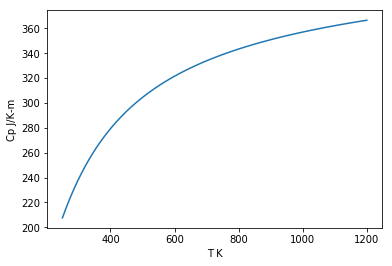

In [11]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
T_array = np.linspace(250.0, 1200.0, 100.0, endpoint=True)
Cp_array = phase.heat_capacity(T_array, 1000.0, mol=moles_end)
plt.plot(T_array, Cp_array)
plt.ylabel('Cp J/K-m')
plt.xlabel('T K')
plt.show()